In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from os.path import basename, join
import glob
from matplotlib import pyplot as plt
import time
from sklearn.model_selection import train_test_split
import random

from tensorflow import keras
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling3D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preprocess:

In [2]:
def resize_frame(img):
    size = img.shape[0]
    start = int((img.shape[1]-img.shape[0])/2)
    new_img = img[:,start:start+size,:]
    new_img = cv2.resize(new_img, (64, 64))
    return new_img

In [3]:
def get_lists(folder):
    name_list = []
    path_list = []
    label = []
    num = 0
    for i in glob.glob(join(folder, '*')):
        name_list.append(basename(i))
        for j in glob.glob(join(i, '*.mp4')):
            path_list.append(j)
            label.append(num)
        num = num+1
    return name_list, path_list, label

In [4]:
def frame_select(frames):
    result_frames = []
    for i in range(10):
        index = (i+1)*int(len(frames)/11)
        result_frames.append(frames[index])
    return result_frames

In [5]:
def frame_select_ex(frames, number):
    result_frames = []
    for i in range(10):
        index = (i+1)*int(len(frames)/11) + int(number)
        result_frames.append(frames[index])
    return result_frames

In [6]:
def collect_data(path_list):
    collect_df = []
    
    for tmp_path in path_list:
        cap = cv2.VideoCapture(tmp_path)
        tmp_df = []

        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()
            if not ret:
                break

            
            tmp_df.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

        cap.release()
        cv2.destroyAllWindows()
        
        tmp_df = frame_select(tmp_df)
        collect_df.append(tmp_df)
        
    return collect_df

In [7]:
def collect_data_ex(path_list, label):
    collect_df = []
    new_label = []
    
    i = 0
    for tmp_path in path_list:
        cap = cv2.VideoCapture(tmp_path)
        tmp_df = []

        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()
            if not ret:
                break

            
            tmp_df.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

        cap.release()
        cv2.destroyAllWindows()
        
        for j in range(9):
            tmp_df = frame_select_ex(tmp_df, j)
            collect_df.append(tmp_df)
            
            new_label.append(label[i])
        
        i = i+1
        
    return collect_df, new_label

In [8]:
# cap = cv2.VideoCapture('train/apple/apple-2.mp4')
# tmp_frames = []

# while cap.isOpened():

#     # Read feed
#     ret, frame = cap.read()
#     if not ret:
#         break


#     tmp_frames.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

# cap.release()
# cv2.destroyAllWindows()

# tmp_frames = frame_select(tmp_frames)

# len(tmp_frames)
# plt.imshow(tmp_frames[10])
# tmp_test = np.array(tmp_frames)
# tmp_test.shape

In [35]:
name_list, path_list, label = get_lists('new_self_data/')

In [36]:
len(name_list)

16

In [37]:
len(path_list)

344

In [38]:
df = collect_data(path_list)

In [39]:
X = np.array(df)/225
X.shape

(344, 10, 64, 64, 3)

In [40]:
y = np.array(label)
y.shape

(344,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [42]:
y_test.shape

(35,)

## Extend Dataset:

In [ ]:
def select_train_test(folder):
    name_list = []
    train_list = []
    test_list = []
    train_label = []
    test_label = []
    
    num = 0
    for i in glob.glob(join(folder, '*')):
        name_list.append(basename(i))
        tmp_test = []
        tmp_train = []
        for j in glob.glob(join(i, '*.mp4')):
            tmp_train.append(j)
            train_label.append(num)
        
        tmp = random.choice(tmp_train)
        tmp_test.append(tmp)
        tmp_train.remove(tmp)
        
        train_list.extend(tmp_train)
        test_list.extend(tmp_test)
        test_label.append(num)
        train_label.pop(-1)
        
        num = num+1
        
    return name_list, train_list, test_list, train_label, test_label

In [ ]:
name_list, train_list, test_list, train_label, test_label = select_train_test('train/')

In [ ]:
len(test_list)

In [ ]:
len(train_list)

In [ ]:
len(train_label)

In [ ]:
df_ex, label_ex = collect_data_ex(train_list, train_label)

In [ ]:
X_train = np.array(df_ex)/225
X_train.shape

In [ ]:
y_train = np.array(label_ex)
y_train.shape

In [ ]:
test_df_ex, test_label_ex = collect_data_ex(test_list, test_label)
X_test = np.array(test_df_ex)/225
X_test.shape

In [ ]:
y_test = np.array(test_label_ex)
y_test.shape

In [ ]:
X_test = collect_data(test_list)
X_test = np.array(X_test)
X_test.shape

In [ ]:
y_test = np.array(test_label)
y_test.shape

## Extend End
### Note, this extension doesn't work. The extended dataset doesn't improve the classification of online videos. We finally only use the video that we record. To use our record dataset, only use the previous section with 'new_self_data/' as input for the get_lists() function. 

# Model Training:

In [ ]:
# # Use this when you didn't shuffle the X_train, since the validation only get the the last data:

# temp = list(zip(X_train, y_train))
# random.shuffle(temp)
# res1, res2 = zip(*temp)
# X_train, y_train = np.array(list(res1)), np.array(list(res2))
# X_train.shape

In [80]:
model = keras.Sequential([
    TimeDistributed(Conv2D(16, (3, 3), padding="same", activation="relu"), input_shape = X_train.shape[1:]),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    Dropout(0.2),
    TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    Dropout(0.2),
    TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    TimeDistributed(Flatten()),
    Dropout(0.2),
    
#     LSTM(64, return_sequences=True, activation='relu'),
#     Dropout(0.2),
#     LSTM(32, return_sequences=True, activation='relu'),
#     Dropout(0.2),
    LSTM(64, return_sequences=False, activation='relu'),
    
    Dense(len(name_list), activation="softmax"),
])

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_152 (TimeD  (None, 10, 64, 64, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_153 (TimeD  (None, 10, 32, 32, 16)   0         
 istributed)                                                     
                                                                 
 dropout_104 (Dropout)       (None, 10, 32, 32, 16)    0         
                                                                 
 time_distributed_154 (TimeD  (None, 10, 32, 32, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_155 (TimeD  (None, 10, 16, 16, 32)   0         
 istributed)                                         

In [81]:
# optimizer = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size = 4, shuffle = True, validation_split = 0.2)

Epoch 1/10
62/62 [==============================] - 8s 112ms/step - loss: 2.8276 - accuracy: 0.0526 - val_loss: 2.7699 - val_accuracy: 0.0484
Epoch 2/10
62/62 [==============================] - 6s 93ms/step - loss: 2.7392 - accuracy: 0.0810 - val_loss: 2.6299 - val_accuracy: 0.0484
Epoch 3/10
62/62 [==============================] - 6s 93ms/step - loss: 2.1339 - accuracy: 0.2753 - val_loss: 1.8430 - val_accuracy: 0.5484
Epoch 4/10
62/62 [==============================] - 6s 94ms/step - loss: 1.1934 - accuracy: 0.6235 - val_loss: 1.2012 - val_accuracy: 0.6290
Epoch 5/10
62/62 [==============================] - 6s 98ms/step - loss: 0.8041 - accuracy: 0.7409 - val_loss: 0.6773 - val_accuracy: 0.7742
Epoch 6/10
62/62 [==============================] - 7s 106ms/step - loss: 0.4740 - accuracy: 0.8462 - val_loss: 0.5339 - val_accuracy: 0.7903
Epoch 7/10
62/62 [==============================] - 6s 99ms/step - loss: 0.3222 - accuracy: 0.9028 - val_loss: 0.3365 - val_accuracy: 0.9194
Epoch 8/10


In [82]:
results = model.evaluate(X_test, y_test)
print('test acuracy:',results[1])

2/2 [==============================] - 0s 15ms/step - loss: 0.0788 - accuracy: 0.9714
test acuracy: 0.9714285731315613


In [85]:
print('Test loss:',results[0])
print('Test acuracy:',results[1])

Test loss: 0.07882425934076309
Test acuracy: 0.9714285731315613


In [74]:
# This model2 refer to: https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/

model2 = keras.Sequential([
    ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = X_train.shape[1:]), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    Flatten(), 
    Dense(len(name_list), activation = "softmax"),
])

model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 10, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_142 (TimeD  (None, 10, 31, 31, 4)    0         
 istributed)                                                     
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 10, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 15, 15, 8)    0         
 g3D)                                                            
                                                     

In [75]:
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs = 10, batch_size = 4, shuffle = True, validation_split = 0.2)

Epoch 1/10
62/62 [==============================] - 34s 434ms/step - loss: 2.7756 - accuracy: 0.0648 - val_loss: 2.7631 - val_accuracy: 0.0484
Epoch 2/10
62/62 [==============================] - 26s 415ms/step - loss: 2.6823 - accuracy: 0.1255 - val_loss: 2.0896 - val_accuracy: 0.5484
Epoch 3/10
62/62 [==============================] - 28s 449ms/step - loss: 1.5934 - accuracy: 0.4899 - val_loss: 1.1682 - val_accuracy: 0.6774
Epoch 4/10
62/62 [==============================] - 30s 478ms/step - loss: 0.7811 - accuracy: 0.7571 - val_loss: 0.7537 - val_accuracy: 0.8226
Epoch 5/10
62/62 [==============================] - 29s 473ms/step - loss: 0.6024 - accuracy: 0.7935 - val_loss: 0.4994 - val_accuracy: 0.8387
Epoch 6/10
62/62 [==============================] - 30s 479ms/step - loss: 0.3741 - accuracy: 0.8947 - val_loss: 0.5479 - val_accuracy: 0.8387
Epoch 7/10
62/62 [==============================] - 28s 460ms/step - loss: 0.2003 - accuracy: 0.9393 - val_loss: 0.3630 - val_accuracy: 0.8871

In [76]:
results2 = model2.evaluate(X_test, y_test)
print('test acuracy:',results2[1])

2/2 [==============================] - 0s 50ms/step - loss: 0.0573 - accuracy: 0.9429
test acuracy: 0.9428571462631226


### From the output we can see that the prediction result of the first model is slightly better than the second model, and the first model has less running time. So, I prefer the first model.

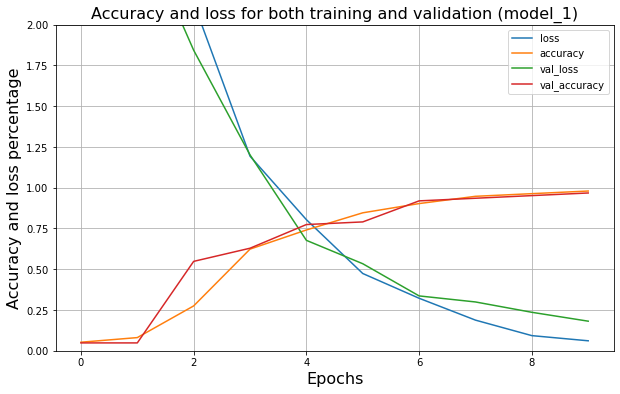

In [84]:
history_dict = history.history
history_dict.keys()

pd.DataFrame(history_dict).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.title('Accuracy and loss for both training and validation (model_1)', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy and loss percentage', rotation=90, fontsize=16)
plt.show()